In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from datetime import timedelta
import itertools
import joblib
import csv

from Functions import plot_centroid_coords

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score
from sklearn.base import clone

from sklearn import set_config
set_config(display="diagram")

In [2]:
# Importation de la base clients
data_cust_raw = pd.read_parquet('data_wrangled/data_cust.parquet')
# Importation du modele
kmeans_pipe = joblib.load('model/kmeans.joblib')
# Importation des variables retenues
with open('model/var_cols.csv', 'r', newline='') as csvfile:
    csv_data = csv.reader(csvfile)
    for row in csv_data:
        var_cols = row
with open('model/var_cols_names.csv',
          'r',
          newline='',
          encoding='utf-8') as csvfile:
    csv_data = csv.reader(csvfile)
    for row in csv_data:
        var_cols_names = row

# 5. Proposition de service

Afin de définir notre proposition de service, dans notre cas la fréquence de mise à jour nécessaire pour assurer la pertinence continue du modèle dans le temps, nous allons tenter d'observer le drift temporel associé à celui-ci. Pour ce faire, nous allons procéder de la manière suivante, par itérations successives : 
- Filtrage de la base pour ne conserver les données des commandes jusqu'à une date choisie
- Entraînement de l'algorithme sur cette base réduite
- Utilisation de l'algorithme ainsi entraîné pour prédire les classes des clients ayant passé des commandes ultérieures à la date sélectionnée
- Comparaison de la classe prédite ainsi à la classe donnée par l'algorithme entraîné sur l'ensemble du set, au travers du score de Rand ajusté

Nous proposons ensuite de définir la fréquence de mise à jour en fonction de l'évolution observée de ce score sur notre échantillon.

## 5.1. Rappel de la classification finale

Nous rappelons ici les détails de la classification finale retenue.

Dans un premier temps, nous rassemblons les étapes de consolidation de la base client par identifiant client unique au sein d'une fonction, après avoir défini un disctionnaire de transformations à appliquer à notre base, sur la base des variables retenues précédemment.

In [3]:
# Colonnes utiles selon l'operation d'aggregation
sum_cols = ['order_item_id', 'price', 'review_score_mean']
count_cols = ['order_id', 'review_id_count']
max_cols = ['order_purchase_timestamp']
mean_cols = ['order_distance']
agg_cols = [sum_cols, count_cols, max_cols, mean_cols]
# Operations d'aggregations retenues
operations = ['sum', 'count', 'max', 'mean']

In [4]:
# Creation d'un dictionnaire des transformations a appliquer
agg_dict = {}

for col_table, operation in zip(agg_cols, operations):
    for col in col_table:
        agg_dict[col] = operation

In [5]:
def customer_consolidation(data, unique_id, agg_dict, date_max=None):

    '''
    Fonction transformant la base de donnees client contenant
    l'ensemble des donnees par commande en une base utilisable
    contenant les donnees par client.

    Parametres :
    ------------
    - data : base client au format cree precedemment
    - unique_id : identifiant contenant l'id client unique
    - agg_dict : dict d'aggregation, pouvant etre utilise par
    une fonction pd.agg()
    - date_max = date limite (optionnelle) pour le calcul de la recence

    Resultat:
    ---------
    DataFrame contenant les donnees concatenees par unique_id,
    suivant les methodes contenues dans agg_dict.
    '''

    data = data.copy()

    # Aggregation des donnees
    data = data.groupby(unique_id, as_index=False).agg(agg_dict)

    # Transformation de certaines donnees
    # Calcul de la moyenne des notes laissees par les clients
    data['review_score_mean'] = data['review_score_mean']\
        .div(data['review_id_count'], axis=0)

    # Creation des categories RFM
    # Recence : nombre de jours depuis la derniere commande
    if date_max is None:
        date_max = data['order_purchase_timestamp'].max()
    else:
        # Permet de definir une date maximale, utile par la suite
        date_max = date_max

    # Recence
    data['rfm_R'] = date_max - data['order_purchase_timestamp']
    # Conversion en jours
    data['rfm_R'] = data['rfm_R'].dt.days

    # Calcul de la longueur, en annees, de la base de donnees
    date_min = data['order_purchase_timestamp'].min()
    time_diff = date_max-date_min
    time_diff = round(time_diff.days/365)

    # Frequence, binaire
    mapping = data['order_id'] == 1
    data.loc[mapping, 'rfm_F'] = 0
    data.loc[~mapping, 'rfm_F'] = 1

    # Montant
    data['rfm_M'] = data['price'] / time_diff

    return data

In [6]:
data_cust = customer_consolidation(data_cust_raw,
                                   'customer_unique_id',
                                   agg_dict)

In [7]:
# Definition des "vraies" classes, auxquelles nous comparerons
# les classes predites par les algorithmes entraines sur des sets reduits
true_labels = kmeans_pipe.fit_predict(data_cust[var_cols])
true_labels = pd.DataFrame(
    true_labels,
    index=data_cust['customer_unique_id'],
    columns=['class']
)

In [8]:
# Extraction des coordonnees des centroides
cluster_centers = kmeans_pipe.named_steps['clustering'].cluster_centers_
# Creation d'une dataframe contenant ces donnees
cluster_data = pd.DataFrame(cluster_centers, columns=var_cols)
# Choix des couleurs pour les representations graphiques
palette = sns.color_palette(n_colors=len(cluster_centers))

Nous visualisons les coordonnées des centroïdes pour nous rappeler ce qu'ils représentent.

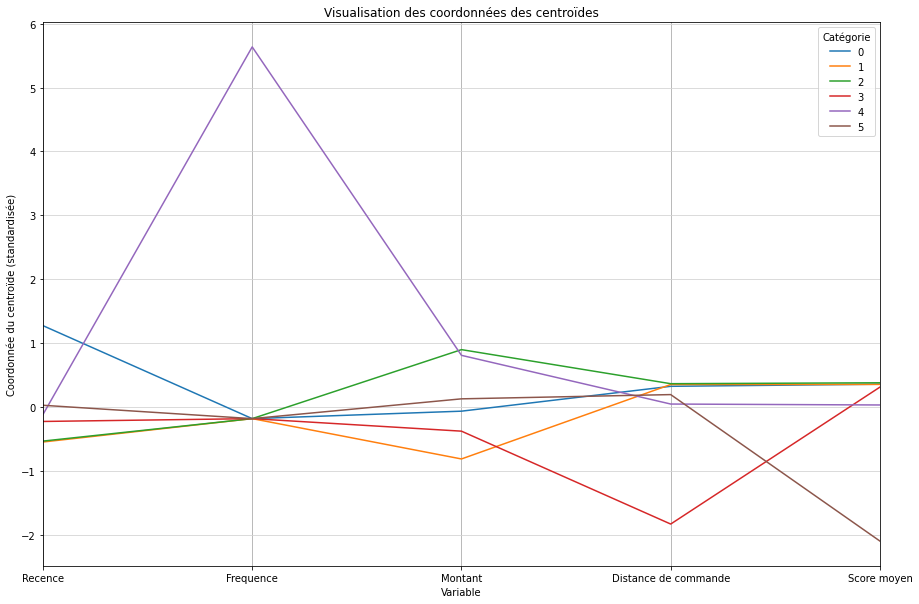

In [9]:
plot_centroid_coords(cluster_data, var_cols_names, palette)
plt.show()

Les catégories identifiées sont les suivantes : 
- catégorie 0 : clients anciens
- catégorie 1 : clients récents, montant faible
- catégorie 2 : clients récents, montant élevé
- catégorie 3 : clients proches du vendeur
- catégorie 4 : clients fréquents
- catégorie 5 : clients insatisfaits

## 5.2. Classification sur période réduite

Nous créons désormais une fonction visant à produire la classification sur une période plafonnée telle que définie initialement, et à comparer la classification prédite sur les valeurs ultérieures à celle obtenue dans la "vraie" classification.

In [10]:
class close_class():

    def fit(self, cluster_centers, compared_clusters):

        """
        Fonction permettant d'identifier, pour chaque label d'un clustering,
        les labels les plus proches resultant d'une autre classification
        similaire.

        Parametres:
        -----------
        - cluster_centers = iterable de coordonnees des centroides resultant
        d'une classification
        - compared_clusters = iterable de coordonnees des centroides auxquels
        il est souhaite de se rapprocher

        Resultat :
        ----------
        list de dict contenant deux cles :
        - 'cluster' : numero du cluster au sein de cluster_centers
        - 'close_class' : numero du cluster le plus proche (distance de
        Manhattan) au sein de compared_clusters
        """

        self.source_clusters_ = np.unique(range(len(cluster_centers)))
        self.updated_clusters_ = np.unique(range(len(compared_clusters)))
        close_class = []

        for i in np.arange(0, cluster_centers.shape[0], 1):
            dist_list = []
            for n in np.arange(0,
                               compared_clusters.shape[0],
                               1):
                dist = np.linalg.norm(compared_clusters[n] -
                                      cluster_centers[i],
                                      ord=1)
                dist_list.append({
                    'n': n,
                    'dist': dist
                })

            min_dist = min(dist_list, key=lambda x: x['dist'])

            close_class.append({
                'cluster': i,
                'close_class': min_dist['n']
            })

        self.close_class_ = close_class
        return self.close_class_

    def predict(self, class_array):

        """
        Fonction remplacant les intitules de clusters au sein d'un
        ndarray par ceux identifies comme etant les plus proches
        au travers d'une list de dict.

        Parametres :
        ------------
        - class_array : ndarray contenant les intitules de clusters a traiter,
        resultant d'une methode .predict() par exemple

        Resultat :
        ----------
        ndarray contenant les intitules de classe resultant du remplacement.
        """

        assert all([n in self.source_clusters_
                    for n in np.unique(class_array)]),\
            ("Les labels doivent tous avoir ete traites avec .predict")
        updated_class = class_array.copy()
        mapping = {}
        for i in np.unique(class_array):
            mapping[i] = class_array == i

        for i in mapping.keys():
            class_match = next(c for c in self.close_class_
                               if c['cluster'] == i)
            updated_class[mapping[i]] = class_match['close_class']

        return updated_class

In [11]:
def ari_check(model, data, var_cols, nb_weeks):

    """
    Fonction calculant l'ARI pour chaque semaine n entre 1 et nb_weeks
    entre la classification a t0 = tmax - nb_weeks et chaque classification
    obtenue en t0 + n.

    Parametres :
    ------------
    - model : modele de clustering
    - data : donnee client brute
    - var_cols : noms des variables prises en compte pour le clustering
    - nb_weeks : nombre de semaines separant la derniere date de data de t0

    Resultat :
    ----------
    - ari_scores : list de dict contenant le nombre de semaines depuis
    l'entrainement et l'ARI obtenu
    - cluster_scores : dict contenant pour chaque cluster l'evolution
    du ri score sur la periode
    """

    assert type(nb_weeks) is int,\
        ("Le nombre de semaines doit etre au format int.")

    data = data.copy()
    scores = []

    # Calcul de la date de fin t0
    t0_date = data['order_purchase_timestamp'].max() -\
        timedelta(nb_weeks*7)

    # Modele a t0
    data_train_t0 = data.loc[data['order_purchase_timestamp'] <= t0_date]
    data_train_t0 = customer_consolidation(data_train_t0,
                                           'customer_unique_id',
                                           agg_dict)
    data_train_t0 = data_train_t0[var_cols]

    t0_model = clone(model)
    t0_model.fit(data_train_t0)

    # Identification des clusters equivalents dans la classification initiale
    t0_class_update = close_class()
    t0_class_update.fit(
        t0_model.named_steps['clustering'].cluster_centers_,
        model.named_steps['clustering'].cluster_centers_
    )

    # Creation d'une list vide pour capturer les scores
    ari_scores = []

    # Creation d'un dict vide pour capturer les scores par cluster
    cluster_scores = dict()
    for i in np.unique(t0_class_update.updated_clusters_):
        cluster_scores[i] = []
    cluster_scores['Nombre semaines'] = []

    # Iteration sur chaque semaine de la prediction
    for week in range(nb_weeks):
        t1_date = t0_date + timedelta((week + 1)*7)
        # Creation d'une base de donnees a t1
        data_t1_raw = data.loc[data['order_purchase_timestamp'] <= t1_date]
        data_t1 = customer_consolidation(data_t1_raw,
                                         'customer_unique_id',
                                         agg_dict)
        data_t1 = data_t1[var_cols]

        # Modelisation sur la base de la data a t1
        t1_model = clone(model)
        t1_model.fit(data_t1)
        t1_class = t1_model.predict(data_t1)

        # Identification des clusters equivalents
        t1_class_update = close_class()
        t1_class_update.fit(
            t1_model.named_steps['clustering'].cluster_centers_,
            model.named_steps['clustering'].cluster_centers_
        )

        # Remplacement des intitules des clusters par les clusters proches
        # dans la classification initiale
        t1_class = t1_class_update.predict(t1_class)

        # Prediction sur base de l'algorithme a t0
        t0_class = t0_model.predict(data_t1)

        # Remplacement des intitules des clusters par les clusters proches
        # dans la classification initiale
        t0_class = t0_class_update.predict(t0_class)

        # Calcul de l'ARI
        ari_scores.append({
            'Nombre semaines': week + 1,
            'ARI': adjusted_rand_score(t1_class, t0_class)
        })

        # Calcul du RI par cluster
        for i in np.unique(t0_class):
            mapping_class = t0_class == i
            cluster_scores[i].append(
                rand_score(t0_class[mapping_class],
                           t1_class[mapping_class]))
        cluster_scores['Nombre semaines'].append(week + 1)

    return ari_scores, cluster_scores

In [12]:
nb_weeks = 15

ari_scores, cluster_scores = ari_check(kmeans_pipe,
                                       data_cust_raw,
                                       var_cols,
                                       nb_weeks)

Nous proposons d'étudier l'évolution du score de Rand ajusté sur la base de mises à jour datant de 1 à 15 semaines.

In [13]:
ari_scores = pd.DataFrame(ari_scores)
cluster_scores = pd.DataFrame(cluster_scores)
cluster_scores.set_index('Nombre semaines', inplace=True)

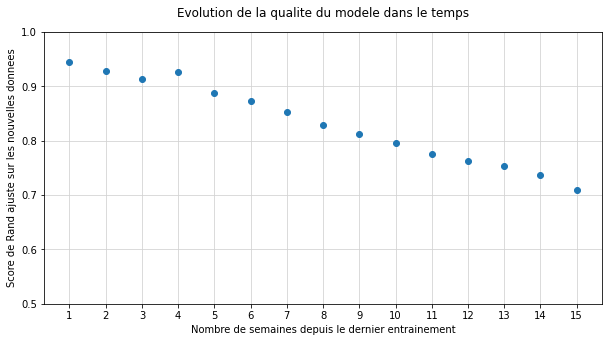

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(
    data=ari_scores,
    x='Nombre semaines',
    y='ARI'
)

ax.grid(visible=True, axis='both', color='lightgrey')
ax.set_axisbelow(True)

ax.set_xticks(ari_scores['Nombre semaines'])
ax.set_ylim(bottom=0.5, top=1.0)

ax.set_xlabel('Nombre de semaines depuis le dernier entrainement')
ax.set_ylabel('Score de Rand ajuste sur les nouvelles donnees')
ax.set_title('Evolution de la qualite du modele dans le temps',
             pad=15)

plt.savefig('figures/model_ARI.png', bbox_inches='tight')

plt.show()

Nous pouvons observer qu'à partir de 10 semaines, la qualité du modèle semble se dégrader matériellement. En tenant compte d'un délai de mise à jour de 1 semaine environ sur la base totale, nous proposons donc de retenir une mise à jour toutes les 9-10 semaines.

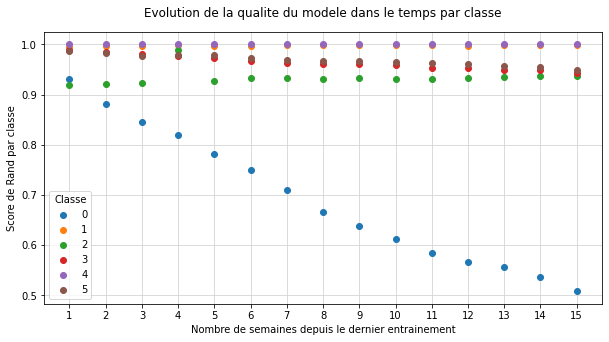

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

for i in cluster_scores.columns:

    ax.scatter(
        x=cluster_scores.index,
        y=cluster_scores[i],
        label=i
    )

ax.grid(visible=True, axis='both', color='lightgrey')
ax.set_axisbelow(True)
ax.legend(title='Classe')

ax.set_xticks(cluster_scores.index)

ax.set_xlabel('Nombre de semaines depuis le dernier entrainement')
ax.set_ylabel('Score de Rand par classe')
ax.set_title('Evolution de la qualite du modele dans le temps par classe',
             pad=15)

plt.savefig('figures/model_class_RI.png', bbox_inches='tight')

plt.show()

En observant les erreurs par classe, nous remarquons que la classe 0 (clients anciens) est, comme attendu, la plus rapidement impactée par l'ancienneté du modèle, le critère d'ancienneté variant directement en fonction de la période totale prise en compte lors de l'entraînement.